<a href="https://colab.research.google.com/github/khaireddine-satouri/plant-dataset/blob/main/Projet_Deep_Learning_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# choix de nombre de lots et époques
EPOCHS = 100
VAL_SUBSPLITS = 5
BUFFER_SIZE = 390
BATCH_SIZE = 16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importation des packages requis

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
import pandas as pd 
import matplotlib.pyplot as plt
from skimage import io
import imageio 
from glob import glob
from tqdm import tqdm
%matplotlib inline 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers

# Collection et stockage des données

In [ ]:
original_images_train_path = '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image'
original_images_test_path = '/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image'
mask_images_train_path = '/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label'
mask_images_test_path='/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label'

In [ ]:
train_image_list=[]
train_mask_list=[]
test_image_list=[]
test_mask_list=[]

In [ ]:
#parcourir la liste des images d'entrainement et les stockées dans une liste
from natsort import natsorted
sorted_train_images_path=[]
for directory_path in glob(original_images_train_path):
    for img_path in glob(os.path.join(directory_path, "*/*.jpg")):
      sorted_train_images_path.append(img_path)
#natsorted(sorted_train_images_path)

In [ ]:
#stockage des images d'entrainement dans une liste d'une facon triée
train_image_list=[]
for img in natsorted(sorted_train_images_path) :
  train_image_list.append(img)

In [ ]:
#parcourir la liste des masques d'images d'entrainement et les stockées dans une liste
from natsort import natsorted
sorted_train_masks_path=[]
for directory_path in glob(mask_images_train_path):
    for img_path in glob(os.path.join(directory_path, "*/*.png")):
      sorted_train_masks_path.append(img_path)
#natsorted(sorted_train_masks_path)

In [ ]:
#stockage des masques d'images d'entrainement dans une liste d'une facon triée
train_mask_list=[]
for img in natsorted(sorted_train_masks_path) :
  train_mask_list.append(img)

In [ ]:
#parcourir la liste d'images de test et les stockées dans une liste
from natsort import natsorted
sorted_test_images_path=[]
for directory_path in glob(original_images_test_path):
    for img_path in glob(os.path.join(directory_path, "*/*.jpg")):
      sorted_test_images_path.append(img_path)
#natsorted(sorted_test_images_path)

In [ ]:
#stockage d'imagesde test dans une liste d'une facon triée
test_image_list=[]
for img in natsorted(sorted_test_images_path) :
  test_image_list.append(img)

In [ ]:
#parcourir la liste des masques d'images de test et les stockées dans une liste
from natsort import natsorted
sorted_test_masks_path=[]
for directory_path in glob(mask_images_test_path):
    for img_path in glob(os.path.join(directory_path, "*/*.png")):
      sorted_test_masks_path.append(img_path)
#natsorted(sorted_test_masks_path)

In [ ]:
#stockage des masques d'images de test dans une liste d'une facon triée
test_mask_list=[]
for img in natsorted(sorted_test_masks_path) :
  test_mask_list.append(img)

(270, 270, 3)
(270, 270, 4)


Text(0.5, 1.0, 'Mask')

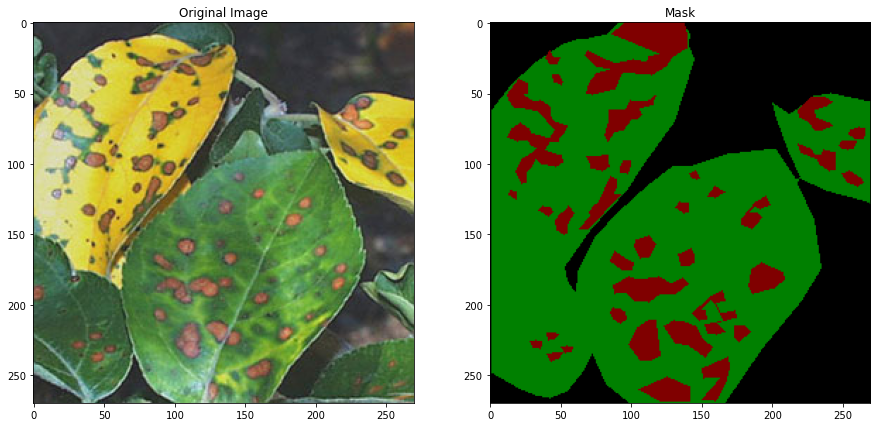

In [ ]:
#verification de l'exactitude des images stockées
n = 10 # you can chose any index 
img  = imageio.imread(train_image_list[n])
print(img.shape)
mask = imageio.imread(train_mask_list[n])
print(mask.shape)

# now let's plot 
fig ,arr  = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

# Préparation des données pour l'entrainement

In [ ]:
train_images = tf.constant(train_image_list)
train_masks = tf.constant(train_mask_list)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))
for image,mask in train_dataset.take(1) : 
    print(image)
    print(mask)
    
test_images = tf.constant(test_image_list)
test_masks = tf.constant(test_mask_list)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_masks))
for image,mask in test_dataset.take(1) : 
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/image/Apple_Rust/train_Apple_Rust_3.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Projet_INFO0702/plant-disease/train/label/Apple_Rust/train_Apple_Rust_3_label.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/image/Apple_Rust/test_Apple_Rust_1.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Projet_INFO0702/plant-disease/test/label/Apple_Rust/test_Apple_Rust_1_label.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path,mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32) #cela revient à diviser par 255 pour définir les valeurs entre 0 et 1 (normalisation)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=1)
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img , mask

def preprocess(image,mask) : 
    input_image = tf.image.resize(image,(96,128),method='nearest')
    input_mask = tf.image.resize(mask,(96,128),method='nearest')
    
    return input_image , input_mask

train_image_ds = train_dataset.map(process_path) # appliquer la fonction preprocess_path à notre train_dataset
print(train_image_ds)
train_processed_image_ds = train_image_ds.map(preprocess) # appliquer la fonction preprocess_path à notre train_dataset

test_image_ds = test_dataset.map(process_path) # appliquer la fonction preprocess_path à notre test_dataset
print(train_image_ds)
test_processed_image_ds = test_image_ds.map(preprocess) 

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>


# Conception de modèle DeepLab

In [ ]:
def EncoderMiniBlock(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def DecoderMiniBlock(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=129):
    
    inputs = Input(input_size)
    
    # contracting path
    cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0.4)
    cblock2 = EncoderMiniBlock(cblock1[0], 2*n_filters, dropout_prob=0.4)
    cblock3 = EncoderMiniBlock(cblock2[0], 4*n_filters, dropout_prob=0.4)
    cblock4 = EncoderMiniBlock(cblock3[0], 8*n_filters, dropout_prob=0.45) 
    cblock5 = EncoderMiniBlock(cblock4[0],16*n_filters, dropout_prob=0.4, max_pooling=None)     
    
    # expanding path
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters*4)
    ublock8 = DecoderMiniBlock(ublock7,cblock2[1] , n_filters*2)
    ublock9 = DecoderMiniBlock(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model



In [ ]:
#réglage des parametres et appel du modèle
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

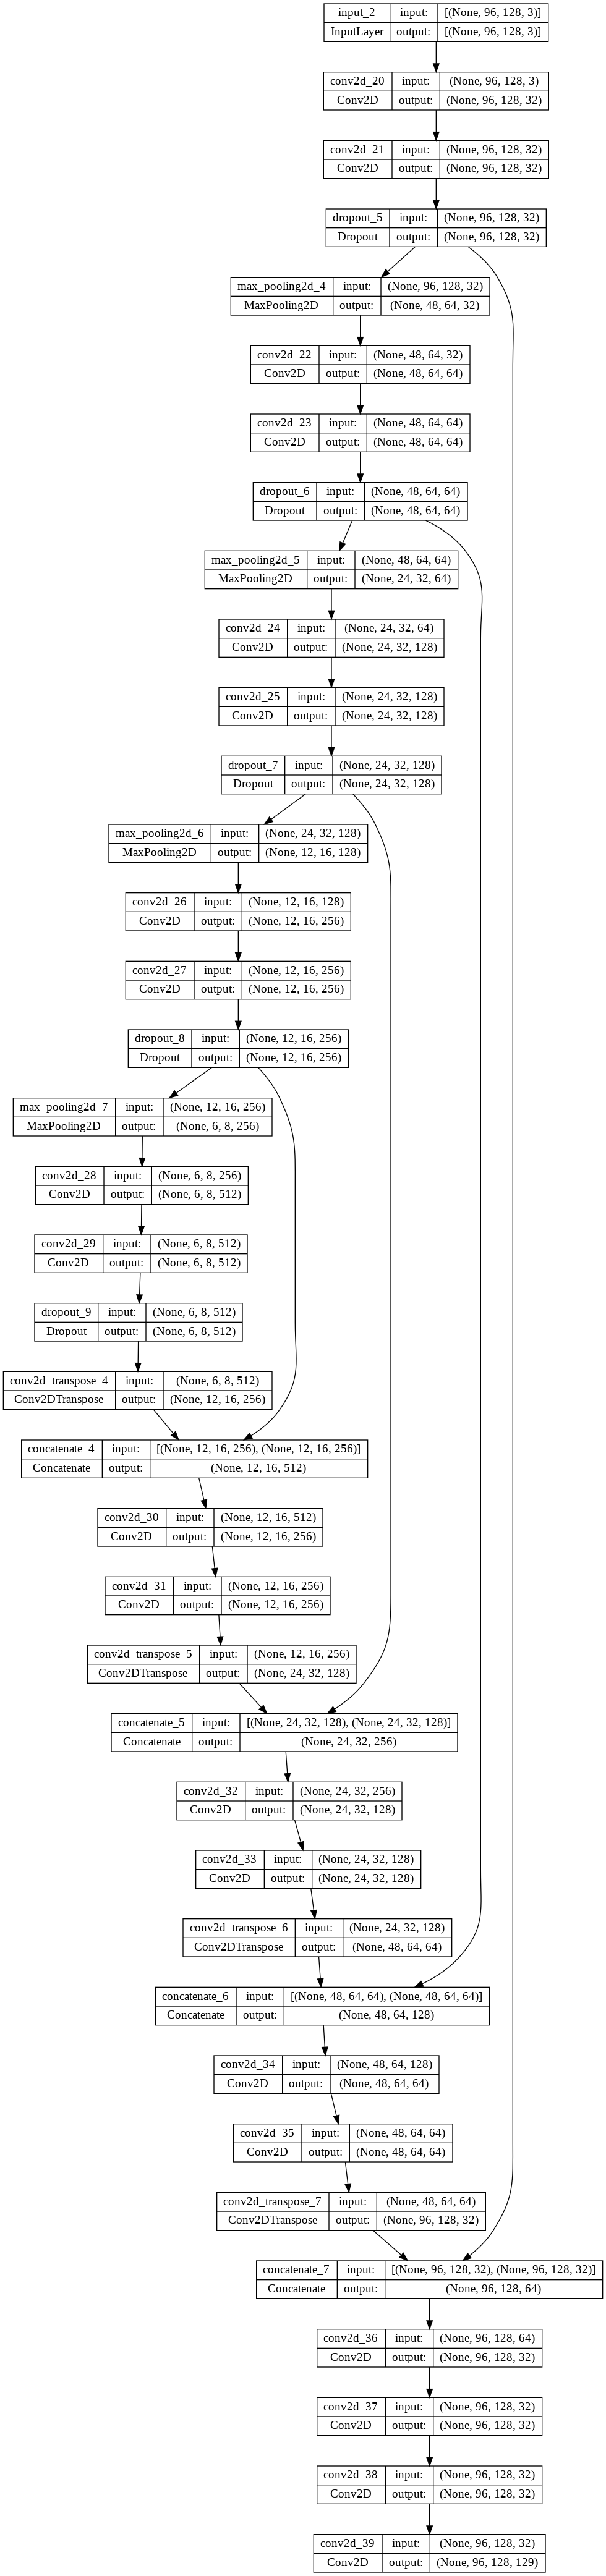

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(unet, show_shapes=True)

# Compilation etntrainement du modèle

In [ ]:
# Compilation du modèle
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
unet.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

In [ ]:
# train
train_processed_image_ds.batch(BATCH_SIZE)
train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_processed_image_ds.element_spec)

# test
test_processed_image_ds.batch(BATCH_SIZE)
test_dataset = test_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(test_processed_image_ds.element_spec)
 
#phase d'entrainement
model_history = unet.fit(train_dataset, 
                    epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/100
29/29 [==============================] - 14s 125ms/step - loss: 2.7340 - accuracy: 0.4394
Epoch 2/100
29/29 [==============================] - 3s 99ms/step - loss: 0.9289 - accuracy: 0.5475
Epoch 3/100
29/29 [==============================] - 3s 100ms/step - loss: 0.8667 - accuracy: 0.6034
Epoch 4/100
29/29 [==============================] - 3s 99ms/step - loss: 0.8074 - accuracy: 0.6455
Epoch 5/100
29/29 [==============================] - 3s 100ms/step - loss: 0.7940 - accuracy: 0.6453
Epoch 6/100
29/29 [==============================] - 3s 99ms/step - loss: 0.7563 - accuracy: 0.6669
Epoch 7/100
29/29 [==============================] - 3s 100ms/step - loss: 0.7485 - accuracy: 0.6660
Epoch 8/100
29/29 [==============================] - 

# Evaluation du modèle


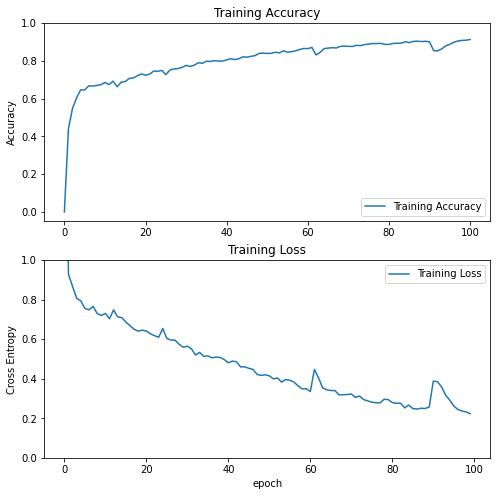

In [ ]:
#visualisation de la progression de la précision
acc = [0.] + model_history.history['accuracy']
#val_acc = [0.] + model_history.history['val_accuracy']

loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='test Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='test Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#sauvegardé le modéle après l'entrainement
unet.save('Unet.h5')

In [ ]:
# évaluation générale du modèle
train_loss, train_accuracy = unet.evaluate(train_dataset, batch_size = 32)


29/29 [==============================] - 2s 44ms/step - loss: 0.2320 - accuracy: 0.9051


# Prédire les segmentations d'images à l'aide du modèle entraîné

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

----- training_dataset results---------
1/1 [==============================] - 0s 270ms/step


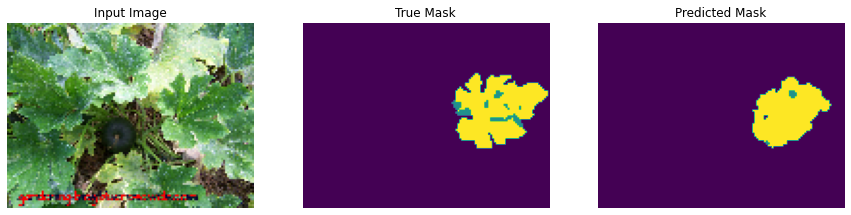

1/1 [==============================] - 0s 19ms/step


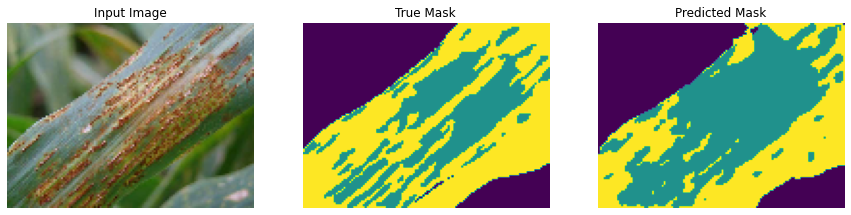

1/1 [==============================] - 0s 21ms/step


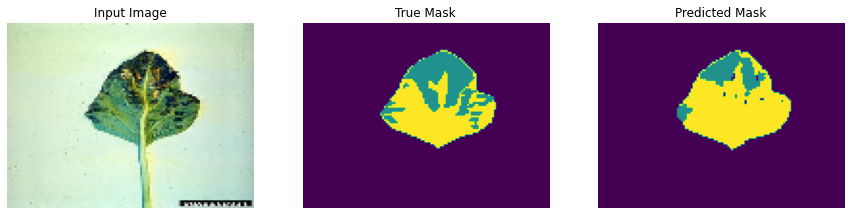

1/1 [==============================] - 0s 23ms/step


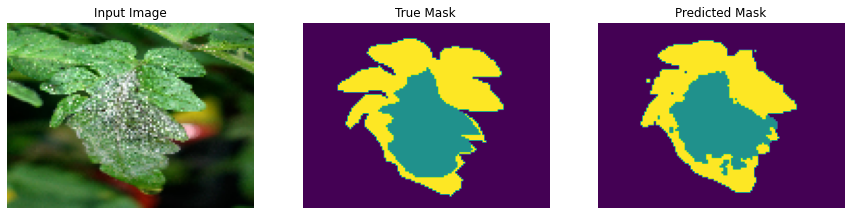

1/1 [==============================] - 0s 19ms/step


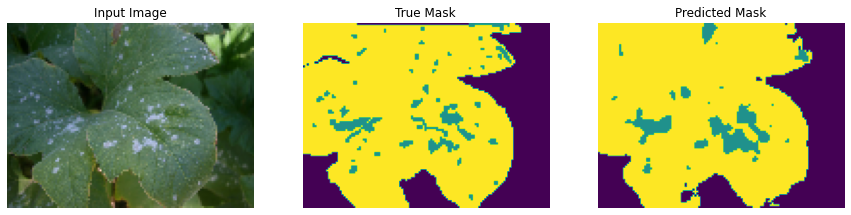

1/1 [==============================] - 0s 21ms/step


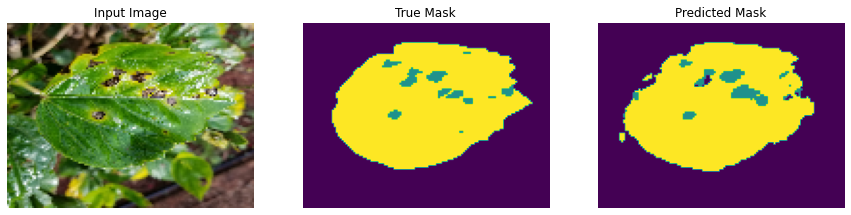

----- test_dataset results---------
1/1 [==============================] - 0s 21ms/step


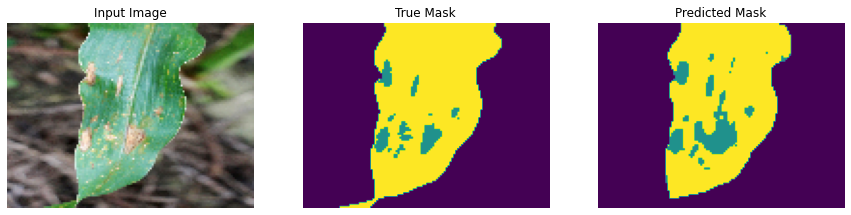

1/1 [==============================] - 0s 18ms/step


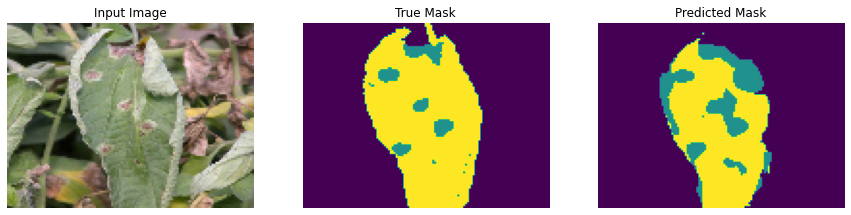

1/1 [==============================] - 0s 20ms/step


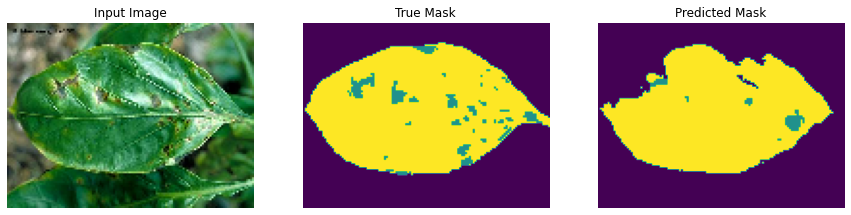

1/1 [==============================] - 0s 24ms/step


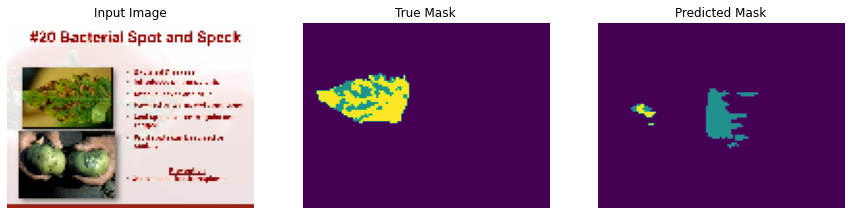

In [ ]:
print("----- training_dataset results---------")
show_predictions(train_dataset, 6)
print("----- test_dataset results---------")
show_predictions(test_dataset, 6)

In [ ]:
# model evaluation
print("Unet Model Evaluation: ")
unet.evaluate(test_dataset)

Unet Model Evaluation: 
4/4 [==============================] - 0s 45ms/step - loss: 0.5149 - accuracy: 0.8293


[0.5148743391036987, 0.8293034434318542]